# Package import

In [27]:
## General
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings
import os 

## Constants and parameters
# from scipy.constants import m, e

## PaulTrapAnalysis
from PaulTrapAnalysis.functions import plotting
from PaulTrapAnalysis.extensions.Electron import big_plt_font, small_plt_font  # plot configuration
from PaulTrapAnalysis.extensions.Electron import import_trap_data, view_result, assign_trap_rf_single_pair  # import data
from PaulTrapAnalysis.extensions.Electron import analyze_trap_height, FindRFNull, analyze_d_eff  # analyze RF null and deff
from PaulTrapAnalysis.extensions.Electron import analyze_radial_frequency, plot_pseudo_contour  # analyze radial frequency
from PaulTrapAnalysis.extensions.Electron import analyze_trap_depth, analyze_trap_frequencies # analyze trap depth, drive frequency, RF amplitude
from PaulTrapAnalysis.extensions.Electron import config_multipoles  # multipole control
from PaulTrapAnalysis.extensions.Electron import display_harmonics_term, display_harmonics_terms  # display spherical harmonics terms
from PaulTrapAnalysis.extensions.Electron import analyze_anharm_DC, analyze_anharm_RF  # analyze DC and RF anharmonicities
from PaulTrapAnalysis.extensions.Electron import get_shift, plot_frequency_shift  # plot the frequency shifts caused by leading order terms

big_plt_font()  # default to a big font size
warnings.filterwarnings('ignore')

In [28]:
from PaulTrapAnalysis.extensions.Electron import *
m_Ca = 6.6551079e-26
def assign_trap_rf_single_pair(trap, prefix, suffix,  
                   V0_rf, electrodes='RF1',
                   l0=100e-6, Ω_e=2*np.pi*2.5e9):
    """
    Assign the imported RF data to the trap, and 
    calculate the pseudopoential. This assumes that the 
    trap only has one pair of RF electrodes.
    
    Parameters
    ----------
    trap : Trap object
        The trap to assign info to
    rf_data : [result_rf0, result_rf1, result_rf2]
        The imported RF result data from .vtk files
    V0_rf : float
        The amplitude for the RF drive
    l0 : [m]  #FIXME
        The length scale of the simulation grid, 
        default is 100e-6 (100 um)

    Returns
    -------
    trap : Trap object
        The updated trap 
    """
    scale = l0 
    trap.l0 = l0
    
    if trap.file_type == 'vtk':
        result_rf1 = Result.from_vtk(prefix+suffix, electrodes)
        rf1_field = result_rf1.field / scale
        rf_potential = V0_rf*result_rf1.potential 
        pp_rf = np.square(rf1_field).sum(axis=0).reshape(result_rf1.grid.shape)
    else:
        result_rf1 = trap.electrodes[electrodes].potential()
        rf1_field = trap.electrodes[electrodes].potential(derivative=1) / scale
        rf_potential = V0_rf*np.array(result_rf1)[:,:,:,0]
        pp_rf = np.array(np.square(rf1_field).sum(axis=-1)).reshape(np.shape(rf_potential))

    trap.result_rf1 = result_rf1
    trap.rf_field = rf1_field 
    
    trap.V0_rf = V0_rf
    trap.rf_potential_data = rf_potential
    
    trap.rf_field_square = pp_rf
    pp_rf = PseudoPotential(pp_rf,m_Ca,Ω_e,V0_rf)
    trap.pp_rf = pp_rf 

    return trap

# Data import and parameter define

In [59]:
prefix = "ben_trap2"
suffix = ""

scale = 10 # conversion scale from BEM units to trap r0 (100um to 1mm)
electrodes = ['RF',
              'DC1', 'DC2', 'DC3','DC4','DC5','DC6','DC7','DC8', 'DC9',
              'DC10', 'DC11', 'DC12', 'DC13', 'DC14', 'DC15','DC16','DC17','DC18','DC19',
              'DC20', 'GND'
              ]  # all electrode names
# elec_file_lookup = {'DC01': 'RF01', 'DC02': 'RF02'}  # look-up table for electrode names if assigned differently in BEM

In [60]:
etrap = import_trap_data(prefix, electrodes, elec_file_lookup={}, scale=scale) 

In [61]:
#etrap.x

# Sanity check

In [62]:
view_result(prefix, suffix, electrode_name='RF')  # display the BEM simulation result (charge distribution of an electrode)

# Trap height, d_eff, radial frequency, trap depth

In [63]:
V0_rf = 35  # voltage applied to RF electrode
omega_rf = 2*np.pi * 30e6  # the RF drive frequency

electrode_name = 'RF'
etrap = assign_trap_rf_single_pair(etrap, prefix, suffix, V0_rf, electrode_name, Ω_e=omega_rf, l0=100e-6)

Approximated RF Null is at 10.00 um
z index of rf null is 40


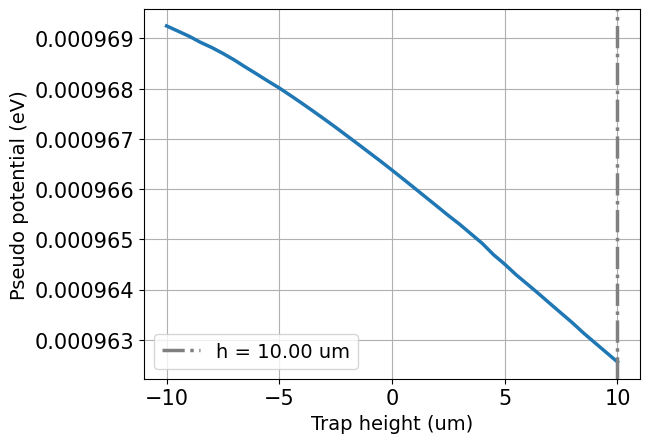

In [64]:
rf_null_z, rf_null_index = analyze_trap_height(etrap, find_saddle=0)  # if find_saddle is True, then use interpolation method to find exact RF null

In [35]:
# analyze_d_eff(etrap, dc_electrode='DC1', direction='z', force_center=False)  # if force_center is True, then RF null is manually set to z=0

In [36]:
# etrap.x = -51.4
# gap_top = -7.929
# middle_electrode = -77
# etrap.y = (gap_top+middle_electrode/2)/(a0*1e6) + 43.69; 

In [37]:
# coord_x, coord_y, coord_z = etrap.result_rf1.grid.to_xyz()
# # etrap.x, etrap.y, etrap.z = coord_y, coord_z, coord_x
# etrap.pp_rf = np.transpose(etrap.pp_rf, axes=(1,2,0))

In [38]:
def parabola(x, x0, amp, b):
    return amp * (x - x0)**2 + b

def analyze_radial_frequency(trap, fit_range=10e-6, 
                             debug=False):
    '''
    Analyze the radial frequency and plot
    
    Parameters
    ----------
    trap : Trap object
        The trap being analyzed
    fit_range : [m]
        Fit range of the pseudo potential, default 10um.
        Note the unit, in SI!
    
    Returns
    -------
    omega_x : [MHz]
        Frequency in x direction
    omega_y : [MHz]
        Frequency in y direction

    Plots
    -----
    plot 1: x&y (um) line cut of pseudop, fit, and deviation
    plot 2: 2D color map (um) of pseudopotential (eV)
    '''
    c = trap.rf_null_index
    x, y = trap.x, trap.y 

    ### Setup axes ###
    scale = trap.l0
    pp_rf = trap.pp_rf 
    a = int(np.floor(pp_rf.shape[0]/2))
    b = int(np.floor(pp_rf.shape[1]/2))
    x_SI = x*scale
    y_SI = y*scale
    px = pp_rf[:, b, c]*e # in J, SI units
    py = pp_rf[a,:,c]*e # in J
    
    fit_xlim1 = x_SI[np.argmin(px)]-fit_range
    fit_xlim2 = x_SI[np.argmin(px)]+fit_range
    argx1 = np.argmin(np.abs(x_SI - fit_xlim1))
    argx2 = np.argmin(np.abs(x_SI - fit_xlim2))
    if debug: 
        print(argx1,argx2)
    fit_ylim1 = y_SI[np.argmin(py)]-fit_range
    fit_ylim2 = y_SI[np.argmin(py)]+fit_range
    argy1 = np.argmin(np.abs(y_SI - fit_ylim1))
    argy2 = np.argmin(np.abs(y_SI - fit_ylim2))
    if debug: 
        print(argy1,argy2)
    
    ### fit the data ###
    poptx, pcovx = curve_fit(parabola, x_SI[argx1:argx2], px[argx1:argx2], p0 = [x_SI[np.argmin(px)], 1E7, 0], xtol=1e-10)
    x0 = poptx[0]
    x_amp = poptx[1]
    x_coordinates = x_SI #- x0
    
    popty, pcovy = curve_fit(parabola, y_SI[argy1:argy2],py[argy1:argy2], p0 = [y_SI[np.argmin(py)], 1E7, 0], xtol=1e-10)
    y0 = popty[0]
    print(y0)
    y_amp = popty[1]
    y_coordinates = y_SI #- y0
    trap.rf_null_x = x0 * 1e6
    trap.rf_null_y = y0 * 1e6  # in um
    
    ### Find trap frequencies ###
    k = 1
    x_range = np.linspace(k*x_coordinates[0],k*x_coordinates[-1], 1000)
    y_range = np.linspace(k*y_coordinates[0],k*y_coordinates[-1], 1000)
    fit_x = parabola(x_range, *poptx) #parabola0(x_range, x_amp)
    fit_y = parabola(y_range, *popty) #parabola0(y_range, y_amp)
    fit_x_match = parabola(x_coordinates, *poptx) #parabola0(x_coordinates, x_amp)
    fit_y_match = parabola(y_coordinates, *popty) #parabola0(y_coordinates, y_amp)
    
    d2Udx2 = 2*x_amp
    trapf_x = TrapFrequency(d2Udx2,m)
    print(f'x trap frequency is about {trapf_x/1E6:.3f} MHz')
    d2Udy2 = 2*y_amp
    trapf_y = TrapFrequency(d2Udy2,m)
    print(f'y trap frequency is about {trapf_y/1E6:.3f} MHz')
    
    ### Plot pseudo-potential fit ###
    small_plt_font()
    
    fig, (ax1, ax2) = plt.subplots(2,1,sharex = True, 
                                   gridspec_kw={'height_ratios': [3, 1]},
                                   figsize=(3.4,3.5), dpi = 200)
    ax1.plot(x*scale*1e6, pp_rf[:, b, c],label = "Pseudo potential along x")
    ax1.plot(x_range*1E6, fit_x/e, '--', label = f"Fit, $f_x$ = {trapf_x/1E6:.2f} MHz")
    ax1.plot(y*scale*1e6,pp_rf[a,:,c],label = "Pseudo potential along y")
    ax1.plot(y_range*1E6, fit_y/e, '--', label = f"Fit, $f_y$ = {trapf_y/1E6:.2f} MHz")
    ax1.grid()
    ax1.legend()
    ax1.set_ylim(-1E-3, k**2*np.max(px)*1.1/e)
    ax1.set_ylabel('Pseudopotential (eV)', size = 8)
    
    ax2.plot(x_coordinates*1E6,(px-fit_x_match)/e, '-', color = 'C1', label='$x$')
    ax2.plot(y_coordinates*1E6,(py-fit_y_match)/e, '-', color = 'C3', label='$y$')
    ax2.set_xlabel('Distance (um)', size = 8)
    ax2.set_ylabel('$\Delta$ (eV)', size = 8)
    ax2.set_ylim(-0.05, 0.05)
    ax2.set_xlim(k*x_coordinates[0]*1E6, k*x_coordinates[-1]*1E6)
    ax2.axhline(y = 0, color = 'grey', linestyle = '-.')
    ax2.grid()
    ax2.legend()
    fig.align_ylabels()
    fig.tight_layout()
    # plt.savefig('Electron_3layer_pseudo_y_1p6GHz_90V.png', bbox_inches = 'tight')
    
    plt.show()
    
    

    return trapf_x, trapf_y

3.0831470440036754e-06
x trap frequency is about 2.330 MHz
y trap frequency is about 2.218 MHz


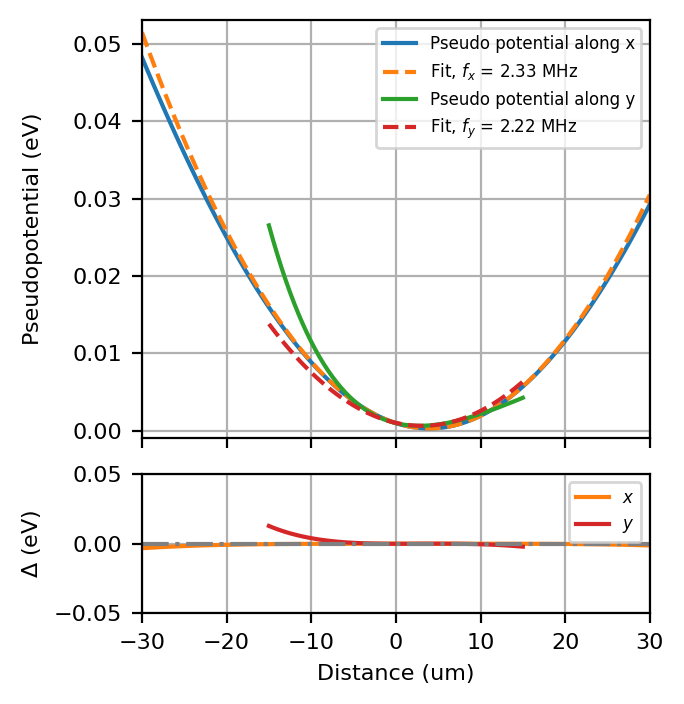

In [39]:
trapf_x, trapf_y = analyze_radial_frequency(etrap, fit_range=5e-6)

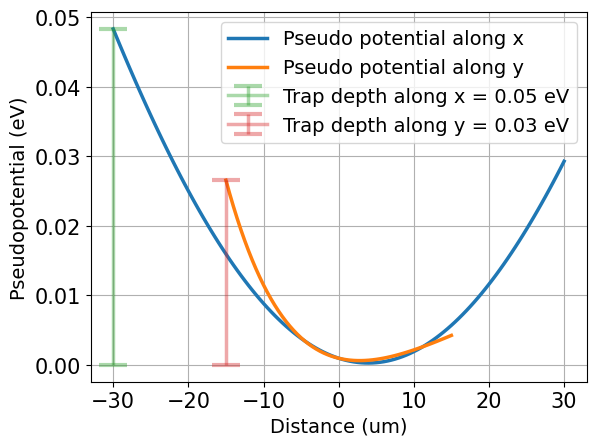

In [40]:
trap_depth = analyze_trap_depth(etrap)

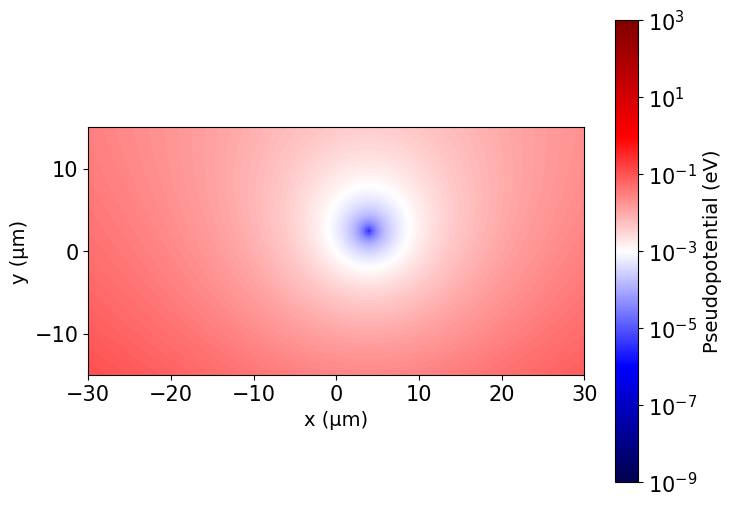

In [41]:
plot_pseudo_contour(etrap, clim=(-9, 3))  # set the color limits in logscale using clim

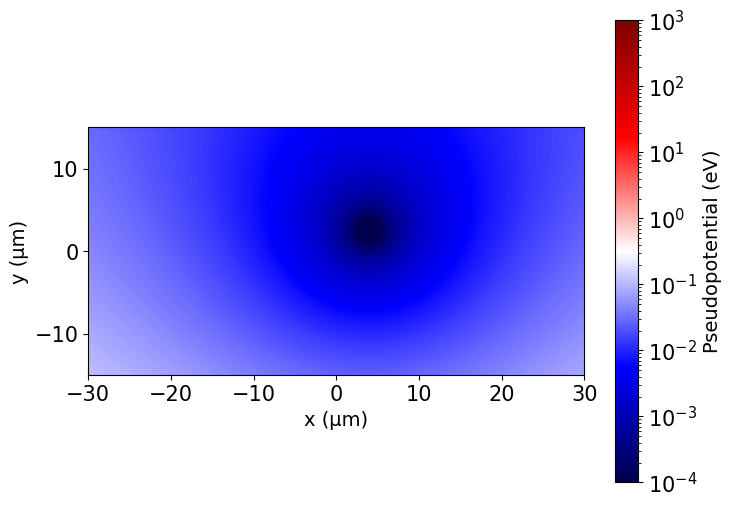

In [42]:
plot_pseudo_contour(etrap, clim=(-4, 3))  # set the color limits in logscale using clim

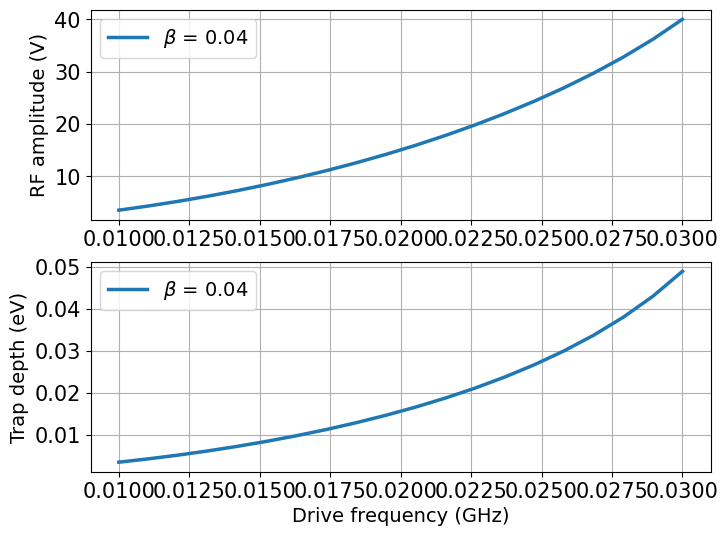

In [43]:
Vs, depths = analyze_trap_frequencies(etrap, beta=1/2*(min(trapf_x, trapf_y)/(omega_rf/2/np.pi)), drive_range=(10e-3, 30e-3))

In [44]:
etrap.rf_null_y

np.float64(3.0831470440036752)

# Multipole control

In [45]:
etrap.z, etrap.rf_null_x

(array([-0.1  , -0.095, -0.09 , -0.085, -0.08 , -0.075, -0.07 , -0.065,
        -0.06 , -0.055, -0.05 , -0.045, -0.04 , -0.035, -0.03 , -0.025,
        -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,
         0.02 ,  0.025,  0.03 ,  0.035,  0.04 ,  0.045,  0.05 ,  0.055,
         0.06 ,  0.065,  0.07 ,  0.075,  0.08 ,  0.085,  0.09 ,  0.095,
         0.1  ]),
 np.float64(3.933032277855613))

In [46]:
etrap.rf_null_x/1000

np.float64(0.003933032277855613)

In [47]:
# create MultipoleControl object, print the multipole_expansion and inverse matrix
controlled_electrodes = [f"DC{i}" for i in range(1, 21)]

rf_electrodes = ['RF']
used_order1multipoles = ['Ey', 'Ez', 'Ex']
used_order2multipoles = ['U3', 'U4', 'U2', 'U5', 'U1']
used_multipoles = used_order1multipoles + used_order2multipoles
# position = [etrap.rf_null_x/1000,etrap.rf_null_y/1000, etrap.z[len(etrap.z)//2]/1000] # trap location, in mm unit
position = [etrap.rf_null_x/1000,etrap.rf_null_y/1000,0] # trap location, in mm unit

nROI = 0.01 # expand the field in a 2*10 um cube
roi = [nROI,nROI,nROI]
order = 4 # expansion order

s = config_multipoles(etrap, position, roi, controlled_electrodes, used_multipoles, order, plot_multipoles=0)
s.rf_elecs = rf_electrodes
print('Multipole names:', s.multipole_names)
print('Normalization factors:', s.normalization_factors)

# s.pinv_matrix
s.multipole_expansion

Multipole names: ['C', 'Ey', 'Ez', 'Ex', 'U3', 'U4', 'U2', 'U5', 'U1']
Normalization factors: [0.28209479 0.48860251 0.48860251 0.48860251 1.09254843 1.09254843
 0.63078313 1.09254843 0.54627422]


,RF,DC1,DC2,DC3,DC4,DC5,DC6,DC7,DC8,DC9,...,DC12,DC13,DC14,DC15,DC16,DC17,DC18,DC19,DC20,GND
C,0.358980,0.012127,0.003975,0.007108,0.007782,0.040127,0.006006,0.005424,0.009158,0.047198,...,0.012618,0.008595,0.004832,0.008668,0.040301,0.003816,0.014393,0.005340,0.035277,0.325364
Ey,0.129272,0.144332,0.050330,0.089864,0.093594,0.372252,0.074795,0.068481,0.113078,0.409403,...,0.148939,0.104536,0.060864,0.106477,0.372419,0.049457,0.166228,0.067682,0.344300,-3.495801
Ez,-0.000977,-0.042422,0.009576,-0.012968,0.026161,0.117995,0.013939,-0.013365,-0.026800,0.150714,...,-0.050173,0.026545,0.008709,-0.030314,-0.176755,0.008014,0.056958,0.007804,-0.136228,-0.002350
Ex,-0.172737,-0.048350,-0.005922,-0.011305,-0.023678,-0.389935,0.013611,0.006501,-0.022979,0.484459,...,0.050948,0.026569,0.008624,0.020950,0.368773,-0.003460,0.067235,0.007657,-0.305863,0.000533
U3,-0.059538,-0.524198,-0.071641,-0.139568,-0.268753,-2.143108,0.159917,0.076794,-0.270048,2.044794,...,0.538071,0.298698,0.103411,0.238695,1.936264,-0.043611,0.677913,0.092756,-1.940936,0.054354
U4,-0.078877,-0.445138,0.118110,-0.159818,0.294707,0.708369,0.164231,-0.163618,-0.311275,0.727361,...,-0.524929,0.294272,0.106044,-0.351453,-0.988364,0.100274,0.547344,0.096917,-0.879740,0.069100
U2,0.024157,0.114038,0.016501,0.022401,0.066291,-0.403101,0.034088,0.025101,0.067206,-0.508558,...,0.140078,0.075604,0.016602,0.077395,-0.049552,0.014856,0.175502,0.012537,-0.076872,-0.020666
U5,-0.010070,0.324915,-0.025677,0.037499,-0.147487,-1.979758,0.060184,-0.031472,0.123685,2.673210,...,-0.367199,0.155103,0.027141,-0.130576,-2.888663,-0.015529,0.513117,0.019417,2.162284,0.007749
U1,24.402339,0.178372,0.018820,0.032023,0.079134,2.472669,0.040843,0.023737,0.072404,3.204222,...,0.195243,0.089213,0.023754,0.071382,2.292825,0.014068,0.274130,0.020899,1.821721,-35.660627
9,-546.169155,0.420423,-0.026987,-0.045963,0.137166,-0.996115,0.001526,-0.058458,0.056097,-5.592339,...,0.412816,0.128050,-0.023085,0.033570,-2.118954,-0.048621,0.614422,-0.050093,0.377495,552.736620


In [48]:
# plot voltage solution of a group of multipole coefficients
def plot_muls(height, position=None, ey=0, ez=0, ex=0, u3=0, u4=0, u2=-2, u5=0, u1=0):
    if position is not None: 
        position1 = position
    else:
        position1 = [0,0,height*1e-3]
    s.update_origin_roi(position1, roi)
    multipole_coeffs = {'Ey': ey, 'Ez':ez, 'Ex': ex, 'U3':u3, 'U4':u4, 'U2':u2, 'U5':u5, 'U1':u1}
    voltages = s.setMultipoles(multipole_coeffs)
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,12))
    fig, ax1 = plt.subplots(figsize = (10,8))
    ax1.bar(s.controlled_elecs, voltages)
    ax1.set_xticklabels(s.controlled_elecs, rotation = 45, fontsize = 12)
    plotting.add_value_labels(ax1)
#     ax1.set_ylim(-25, 40)
    ax1.set_ylabel('V')
    return voltages

In [49]:
def MHz_to_U2(f_MHz): 
    return 1/2*m*(2*np.pi*f_MHz*1e6)**2/1e6/e

In [50]:
MHz_to_U2(1)

8.19925604027559

# Anharm analysis

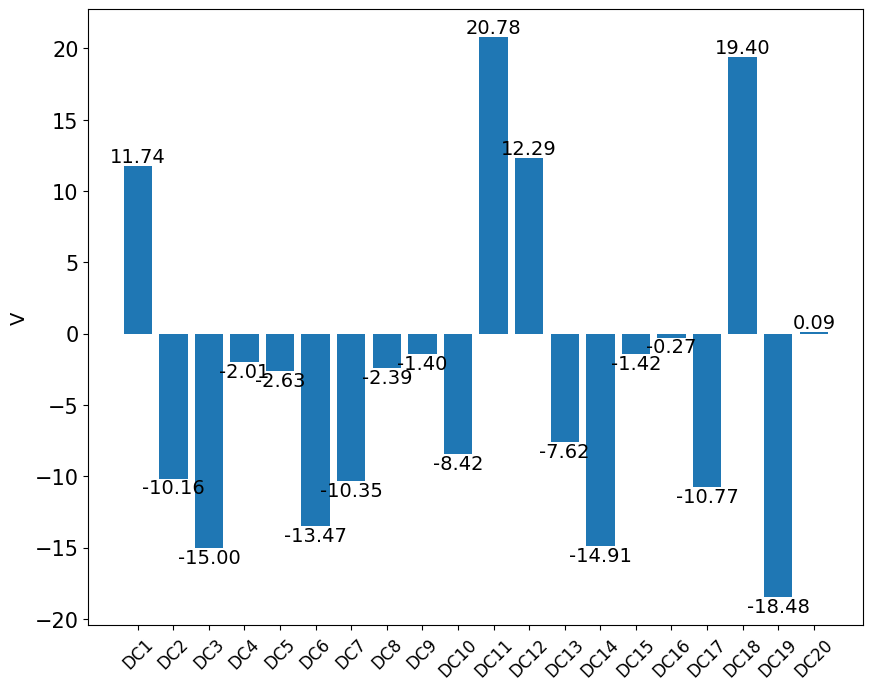

In [51]:
DC_voltages = plot_muls(etrap.rf_null_z, position, u2=MHz_to_U2(1))  # compensating by changing m21 values
#Mj_DC0 = analyze_anharm_DC(s, np.around(DC_voltages, decimals=3), position, nROI, order=4, Mj_threshold=0.05)

>>> Fitting using ROI only
>>> Using manual Harmonic Basis
>>> Using Least Square


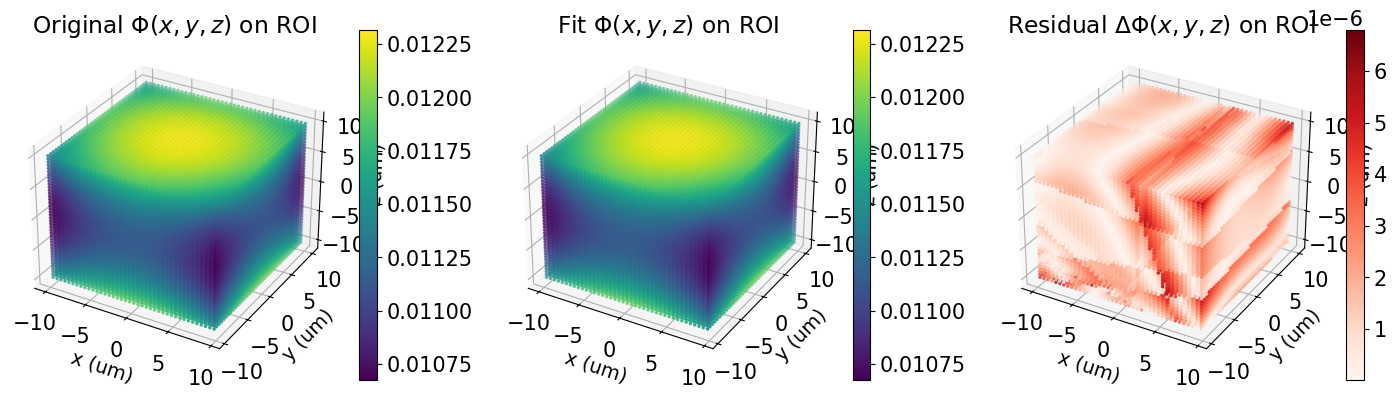

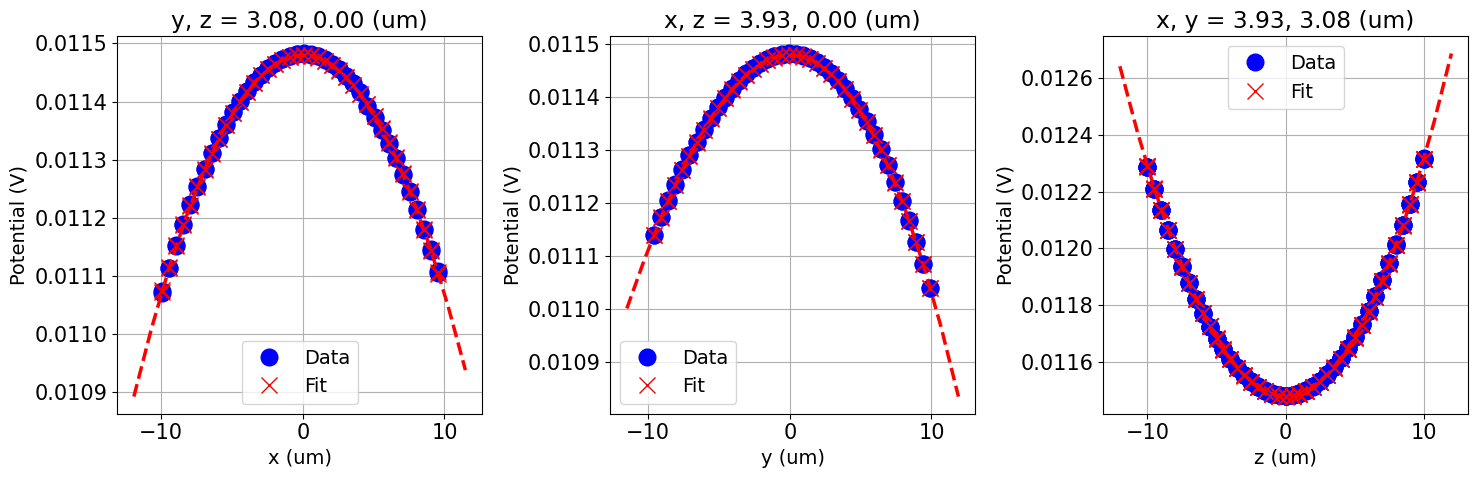

,Mj
C,1.148e-02
Ey,4.996e-16
Ez,-2.709e-18
Ex,-1.633e-15
U3,-6.494e-15
U4,-7.651e-15
U2,8.199e+00
U5,-3.912e-14
U1,1.418e-14
10,-1.991e+00


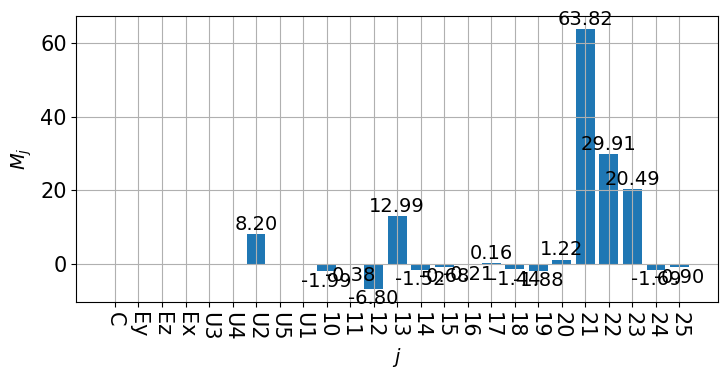

In [52]:
Mj_DC0 = analyze_anharm_DC(s, DC_voltages, position, nROI, order=4, Mj_threshold=0.05)

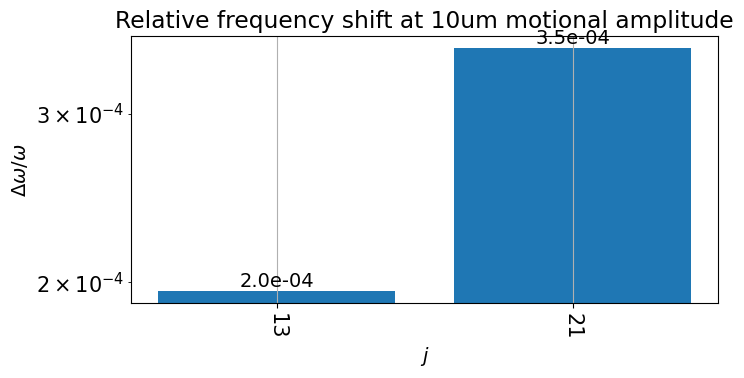

In [53]:
plot_frequency_shift(Mj_DC0, A=10)  # plot the projected frequency shifts at a given motional amplitude set by A

In [54]:
get_shift(j=31, Mj=13, M2=0.55, A=10)  # get the frequency shift of a term j with fitting coefficient Mj, with some M2 value and amplitude A 

np.float64(6.777482898090263e-10)

In [55]:
display_harmonics_terms(21, 29, 31, 41, 42, 43, 45)

21:


0.375*x**4 + 0.75*x**2*y**2 + 0.375*y**4 + z**4 - z**2*(3*x**2 + 3*y**2)

29:


210*x*y*z**3 - z*(105*x**3*y + 105*x*y**3)

31:


z**5 - z**3*(5*x**2 + 5*y**2) + z*(1.875*x**4 + 3.75*x**2*y**2 + 1.875*y**4)

41:


26.25*x**5*y + 52.5*x**3*y**3 + 26.25*x*y**5 + 420*x*y*z**4 - z**2*(420*x**3*y + 420*x*y**3)

42:


-21*y*z**5 + z**3*(52.5*x**2*y + 52.5*y**3) - z*(13.125*x**4*y + 26.25*x**2*y**3 + 13.125*y**5)

43:


-0.3125*x**6 - 0.9375*x**4*y**2 - 0.9375*x**2*y**4 - 0.3125*y**6 + z**6 - z**4*(7.5*x**2 + 7.5*y**2) + z**2*(5.625*x**4 + 11.25*x**2*y**2 + 5.625*y**4)

45:


13.125*x**6 + 13.125*x**4*y**2 - 13.125*x**2*y**4 - 13.125*y**6 + z**4*(210*x**2 - 210*y**2) - z**2*(210*x**4 - 210*y**4)

>>> Fitting using ROI only
>>> Using manual Harmonic Basis
>>> Using Least Square


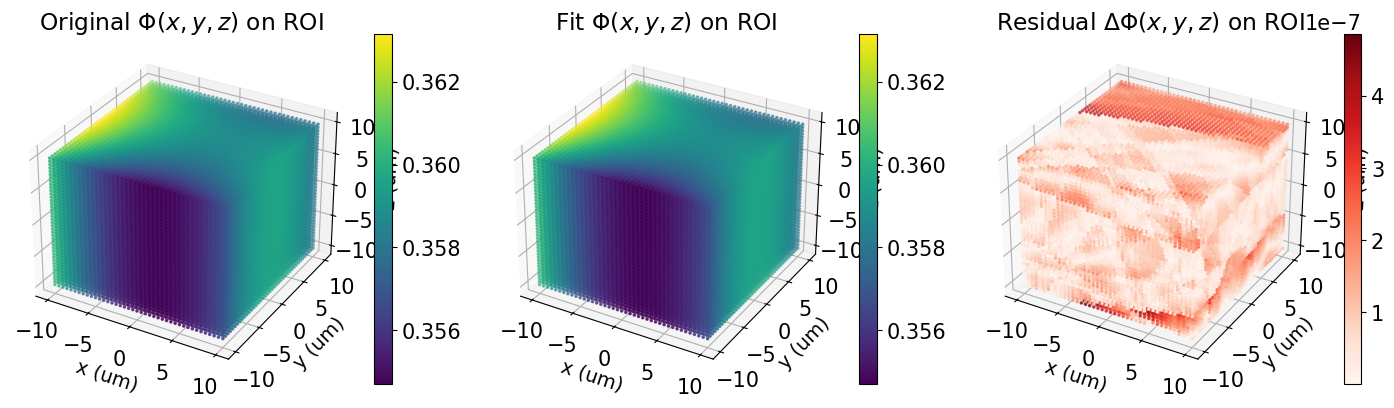

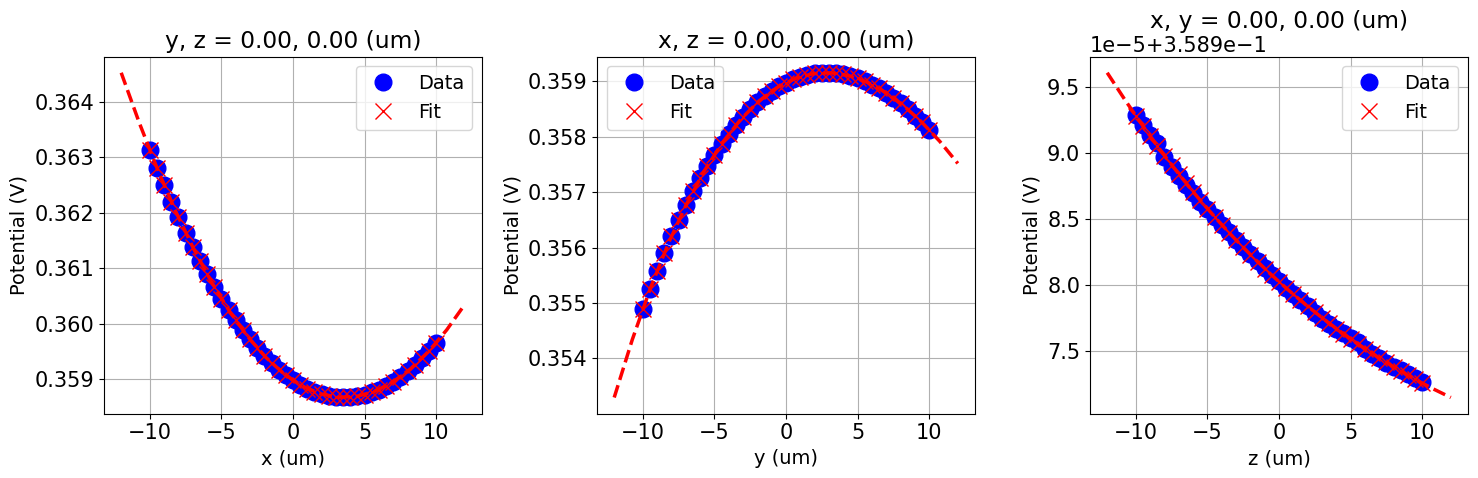

,Mj
C,3.590e-01
Ey,-1.294e-01
Ez,-9.743e-04
Ex,1.727e-01
U3,-9.901e-03
U4,2.629e-02
U2,2.413e-02
U5,3.352e-03
U1,8.134e+00
10,2.145e+01


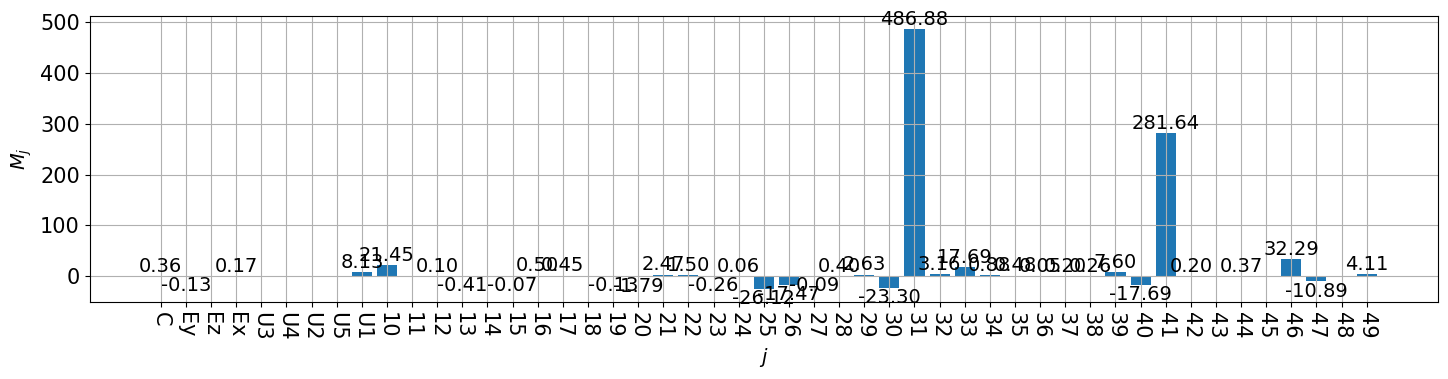

In [56]:
Mj_RF0 = analyze_anharm_RF(s, [1], [0,0,0], nROI, order=6)

# Trajectory stability

In [57]:
''' uncomment if needing to save Mj
import esim
scale = 1e3
order = 4
Mj_DC = data.rescale_Mj(Mj_DC0, scale, order).flatten()
Mj_RF = data.rescale_Mj(Mj_RF0, scale, order).flatten()
np.savez(os.path.join(esim.data_dir, f'3layer_v2_0_4.npz'), DC=Mj_DC[1:], RF=Mj_RF[1:], 
                                                                DC0=Mj_DC, RF0=Mj_RF)
'''

" uncomment if needing to save Mj\nimport esim\nscale = 1e3\norder = 4\nMj_DC = data.rescale_Mj(Mj_DC0, scale, order).flatten()\nMj_RF = data.rescale_Mj(Mj_RF0, scale, order).flatten()\nnp.savez(os.path.join(esim.data_dir, f'3layer_v2_0_4.npz'), DC=Mj_DC[1:], RF=Mj_RF[1:], \n                                                                DC0=Mj_DC, RF0=Mj_RF)\n"

In [58]:
def plot_trajectory():
    '''For a given set of voltages, simulate the trajectory of the particle to make sure it's stable
    do fft to extract the trap frequencies and compare with our expectation from the multipole values
    '''